In [1]:
import pandas as pd 
import geopandas as gpd

# BAN utils

liste de petits utilitaires pour récupérer des informations de la ban


## get communes

<AxesSubplot:>

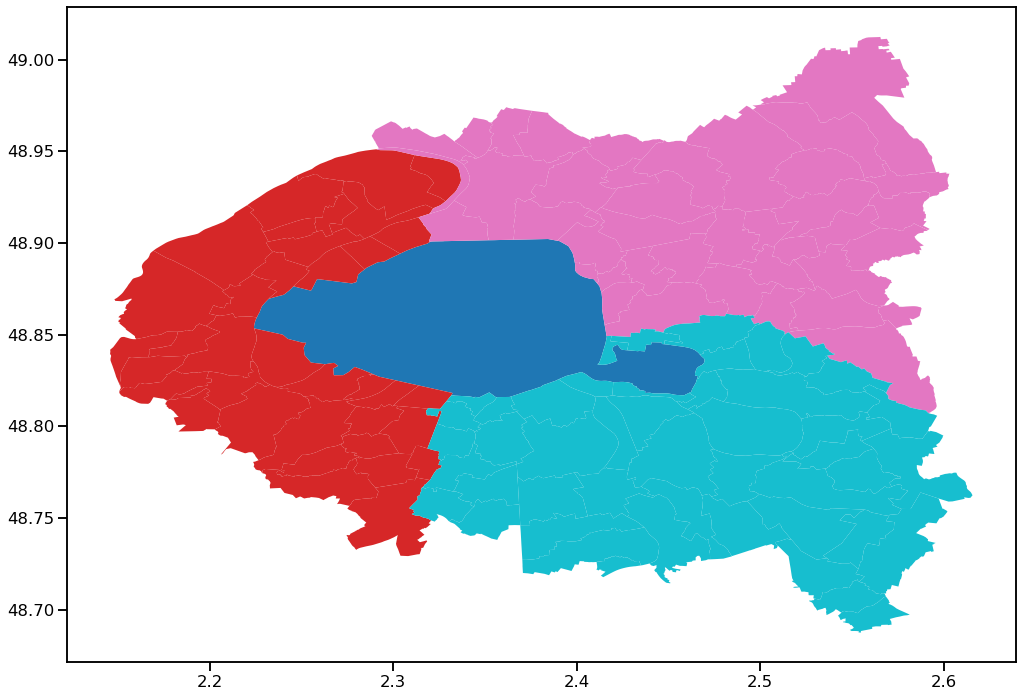

In [2]:
from geocoding_tools.ban_utils import get_communes_table_by_dept
com_ban_geo = get_communes_table_by_dept(['75','92','93','94'])

com_ban_geo.plot(figsize=(17,17),column='codeDepartement')

## correspondance code insee code postal flat

In [3]:
from geocoding_tools.ban_utils import build_communes_cp_table_flat

In [4]:
df_code_cp_flat = build_communes_cp_table_flat(com_ban_geo)


## get ban addr

In [5]:
from geocoding_tools.ban_utils import get_ban_addr_by_dept
from shapely.geometry import Point
import geopandas as gpd

In [6]:
ban_addr_geo= get_ban_addr_by_dept('75')

In [7]:
ban_addr_geo.head()

id id_fantoir numero  rep                     nom_voie  \
0  75101_cfq3tf_00001        NaN      1  NaN  Avenue du Général Lemonnier   
1  75101_cfq3tf_00002        NaN      2  NaN  Avenue du Général Lemonnier   
2  75101_cfq3tf_00003        NaN      3  NaN  Avenue du Général Lemonnier   
3  75101_cfq3tf_00004        NaN      4  NaN  Avenue du Général Lemonnier   
4  75101_cfq3tf_00005        NaN      5  NaN  Avenue du Général Lemonnier   

  code_postal code_insee               nom_commune  \
0       75001      75101  Paris 1er Arrondissement   
1       75001      75101  Paris 1er Arrondissement   
2       75001      75101  Paris 1er Arrondissement   
3       75001      75101  Paris 1er Arrondissement   
4       75001      75101  Paris 1er Arrondissement   

  code_insee_ancienne_commune nom_ancienne_commune  ...           y       lon  \
0                         NaN                  NaN  ...  6862571.27  2.330113   
1                         NaN                  NaN  ...   6862544.4  2.330403   
2                         NaN                  NaN  ...   6862595.3  2.330265   
3                         NaN                  NaN  ...  6862565.22  2.330548   
4                         NaN                  NaN  ...  6862619.33  2.330423   

         lat alias nom_ld libelle_acheminement                    nom_afnor  \
0  48.861299   NaN    NaN                PARIS  AVENUE DU GENERAL LEMONNIER   
1  48.861059   NaN    NaN                PARIS  AVENUE DU GENERAL LEMONNIER   
2  48.861516   NaN    NaN                PARIS  AVENUE DU GENERAL LEMONNIER   
3  48.861247   NaN    NaN                PARIS  AVENUE DU GENERAL LEMONNIER   
4  48.861733   NaN    NaN                PARIS  AVENUE DU GENERAL LEMONNIER   

  source_position source_nom_voie                  geometry  
0         commune         commune  POINT (2.33011 48.86130)  
1         commune         commune  POINT (2.33040 48.86106)  
2         commune         commune  POINT (2.33026 48.86152)  
3         commune         commune  POINT (2.33055 48.86125)  
4         commune         commune  POINT (2.33042 48.86173)  

[5 rows x 21 columns]

# geocode table

Le coeur du module est de fournir des process tout intégrés pour géocoder des données avec la ban.  


## config addok urls

avant tout géocodage, configurer les urls du service addok. Par défaut ceux-cis pointent sur le service en ligne https://adresse.data.gouv.fr à vocation de tests sur de petits échantillons. 

il est essentiel de changer les urls de productions de géocodage nottament pour le géocodage csv

In [8]:
from geocoding_tools.config import addok_ban_urls

In [9]:
addok_ban_urls

{'ADDOK_URL': 'https://api-adresse.data.gouv.fr',
 'GEO_API_URL': 'https://geo.api.gouv.fr',
 'BAN_ADDR_DEPT_URL': 'https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-{dept}.csv.gz',
 'ADDOK_SEARCH_CSV_URL': 'https://api-adresse.data.gouv.fr/search/csv',
 'ADDOK_SEARCH_URL': 'https://api-adresse.data.gouv.fr/search/?q=',
 'COMMUNES_DEPT_URL': 'https://geo.api.gouv.fr/departements/{code}/communes?format=geojson'}

In [10]:
addok_ban_urls['ADDOK_SEARCH_CSV_URL']='your/addok/url'
addok_ban_urls['ADDOK_SEARCH_CSV_URL']='https://api-adresse.data.gouv.fr/search/csv'

## geocode simple

La méthode geocode simple est la méthode de géocodage basique qui réalise un géocodage avec très peu de retravail sur les données brutes d'adresses du jeu de données à géocoder. Ici dans l'exemple un échantillon du jeu de données des données locales de l'énergie d'ENEDIS(https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2020-05/donnees-electricite-2018.zip) est géocodé avec cette méthode car la base d'adresse d'ENEDIS est plutôt propre et standardisée avec la poste et necessite donc peu de retravail.

### import

In [1]:
from pkg_resources import resource_filename
import pandas as pd
from geocoding_tools.geocode_table import simple_geocode_table,advanced_geocode_table
from geocoding_tools.geocode_table import *

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy-0.18.0-py3.8.egg\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### lecture de l'échantillon de donnée

In [2]:
file_path = resource_filename('geocoding_tools','tests/sample_data/sample_dle_enedis_2018.csv')
table = pd.read_csv(file_path,index_col=0,dtype='str')
table['code_insee'] = table.CODE_IRIS.apply(lambda x: x[0:5]) # code insee récupéré de l'iris. 

### config + appel au géocodeur 

on configure l'appel au géocodeur en renseignant les champs adresses , communes, code postal , code insee

In [3]:
addr_cols_ordered = ['ADRESSE'] # pour les données enedis un seul champs adresse est utilisé(obligatoire)
cityname_col = 'NOM_COMMUNE' # le champs du nom de la commune(optionnel : fortement recommandé)
citycode_col = 'code_insee' # le champs du code insee(recommandé)
postcode_col = None # pas de code postal dans la base enedis(recommandé)
keep_debug_cols = True # garde les colonnes intermédiaire de calcul du géocodage (a desactiver pour optimiser mémoire)
id_col = None # colonne d'identifiant utilisé dans l'échantillon (sinon par défaut génère un id qui est le numéro de ligne en format str)
addok_search_csv_kwargs = None # keyword arguments passés à l'appel à addok_search_csv(geocoding_tools.addok_utils.run_get_addok_search_csv_by_chunks)
dept_col = None # colonne renseignant le département
simple_geocoding_score_threshold = 0.8

In [4]:
table_geo_simple=simple_geocode_table(table,addr_cols_ordered=addr_cols_ordered,cityname_col=cityname_col,citycode_col=citycode_col,
                      postcode_col=postcode_col,keep_debug_cols=True,id_col=id_col,trusted_codes=None)

d:\cstbdata\monworkspace\gitlab\geocoding_tools\geocoding_tools\addr_utils.py:88: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace('\.0', '').replace('nan', '')


19 duplicates detected
geocoding 981 instead of 1000
===============RETRY============================
===============0============================
981 981
0 chunk started....
query https://api-adresse.data.gouv.fr/search/csv
status_code:  200
encoding_error: utf-8 using ansi instead. 
success
===============RETRY============================
===============1============================
0 0


## geocode advanced (example DPE)

La méthode geocode avancée utilise extensivement les champs **commune** **code postal** **code insee** pour générer  un ensemble de champs commune auquel peut appartenir l'adresse fournie. Cela est utile lorsque le jeu de donnée à géocoder n'a pas été basé sur une base d'information fiable comme la BAN la poste ou les api de google par exemple.  Les champs **commune** **code postal** **code insee** peuvent alors être discordants, on peut aussi avoir des adresses dans les milieux ruraux affectés aux petites communes voisines ou a une autre commune d'un même code postal. C'est pour corriger tous ces cas pathologiques que cette méthode est mise en place. Afin de ne pas faire exploser le nombre de géocodage effectif, il est effectué d'abord un géocodage simple pour lequel on garde seulement les très bon résultats puis on lance ce géocodage avancé sur le reste des adresses ayant obtenues des scores moins élevés. 

Un exemple adapté à ce géocodage avancé est la base DPE pour laquelle les champs **commune** **code postal** et **code insee** sont saisis manuellement et donc avec plus de chance d'erreur de saisie.  


### import

In [15]:
from pkg_resources import resource_filename
import pandas as pd
from geocoding_tools.geocode_table import simple_geocode_table,advanced_geocode_table
from geocoding_tools.scripts_specific_bases.dpe import cleanup_dpe_table

### lecture de l'échantillon de donnée

dans geocoding tools certains scripts de nettoyages ont été établis pour certains jeux de données nottament ceux donnés en exemple. 

In [16]:
from geocoding_tools.scripts_specific_bases.dpe import cleanup_dpe_table

In [17]:
file_path = resource_filename('geocoding_tools','tests/sample_data/sample_td001_dpe_38.csv')
table = pd.read_csv(file_path,dtype=str,index_col=0)
table = cleanup_dpe_table(table)

### simple geocoding (pour comparaison)

In [18]:

# attention ici on a l'adresse renseignée sur plusieurs champs. IL EST IMPORTANT DE FOURNIR LA LISTE ORDONNEE DES CHAMPS! 
addr_cols_ordered=['numero_rue','type_voie','nom_rue'] 
cityname_col='commune'
citycode_col='code_insee'
postcode_col='code_postal'
keep_debug_cols=False
id_col='numero_dpe'
addok_search_csv_kwargs=None
dept_col=None
simple_geocoding_score_threshold=0.8

table_geo_simple=simple_geocode_table(table.copy(),addr_cols_ordered=addr_cols_ordered,cityname_col=cityname_col,citycode_col=citycode_col,
                      postcode_col=postcode_col,keep_debug_cols=True,id_col=id_col)

===============RETRY============================
===============0============================
1000 1000
0 chunk started....
query https://api-adresse.data.gouv.fr/search/csv
status_code:  200
success
===============RETRY============================
===============1============================
0 0


### advanced geocoding

On notera lorsque l'on passe au géocodage avancé la multiplication des adresses qui sont géocodées ce qui correspond à la méthode expliquée plus haut

In [19]:
table_geo_adv,comb=advanced_geocode_table(table.copy(),addr_cols_ordered=addr_cols_ordered,cityname_col=cityname_col,citycode_col=citycode_col,
                      postcode_col=postcode_col,keep_debug_cols=True,id_col=id_col)

starting geocoding simple with 1000 adddress.....
===============RETRY============================
===============0============================
1000 1000
0 chunk started....
query https://api-adresse.data.gouv.fr/search/csv
status_code:  200
success
===============RETRY============================
===============1============================
0 0
607 address geocoded with the simple method. trying advanced method for the rest
===============RETRY============================
===============0============================
3130 3130
0 chunk started....
query https://api-adresse.data.gouv.fr/search/csv
status_code:  200
success
1 chunk started....
query https://api-adresse.data.gouv.fr/search/csv
status_code:  200
success
2 chunk started....
query https://api-adresse.data.gouv.fr/search/csv
status_code:  200
success
3 chunk started....
query https://api-adresse.data.gouv.fr/search/csv
status_code:  200
success
===============RETRY============================
===============1==================

### comparaison

In [20]:
table_geo_adv = table_geo_adv.sort_values(id_col)
table_geo_simple = table_geo_simple.sort_values(id_col)

In [21]:
bool_diff = table_geo_adv.result_id != table_geo_simple.result_id
bool_imp = table_geo_adv.result_score > table_geo_simple.result_score +0.1

In [22]:
table_geo_simple.loc[bool_diff&bool_imp][[id_col,'address_concat','result_id','result_label','result_city','result_score']]

numero_dpe                                     address_concat  \
311  1338I2000001Y                   Place Du Village 38510 Courtenay   
678  1338L1000113E               86 Avenue Jean Perrot 38000 Grenoble   
707  1338L1000114F            La Cassey 38830 Saint Pierre D Allevard   
943  1338L1000137K                    Le Champ 38390 Bouvesse Quirieu   
528  1338L2000033G                         17 Grande Rue 38700 Corenc   
739  1338L2000060G        144 Chemin Des Sources 38690 Le Grand Lemps   
844  1338L2000073K       Les Paquerettes 17 Vie De Boussieu 38300 Ruy   
968  1338L2000094N                   Ferme Du Gibet Rd41 38260 Semons   
33   1338V1000023F  Les Sapins 1 Station De Prapoutel 38190 Les Ad...   
71   1338V1000049N                 9 Chemin De Bardonnanche 38450 Vif   
134  1338V1000082K                      Les Coquelicots 38430 Moirans   
507  1338V1000254L    Residence La Grande Chaume 38860 Les Deux Alpes   
685  1338V1000314I  Chalet Millepertuis Route De Saint Eynard 3870...   
762  1338V1000347O              157 Avenue Jean Perrot 38000 Grenoble   
942  1338V1000395R              9 Impasse De La Vie Etroite 38300 Ruy   
258  1338V2000062J                   Res Les Granges 38130 Echirolles   
284  1338V2000072K       1118 Route National 7 38121 Reventin Vaugris   
286  1338V2000073L  Rue Du 19 Mars 1962 38620 Saint Geoire En Vald...   
570  1338V2000135K               33 Route De Four 38090 Villefontaine   
623  1338V2000145L              Sailles 38830 Saint Pierre D Allevard   
776  1338V4000028N          26 Avenue Marechal Leclerc 38000 Grenoble   
791  1338V4000029O                 30 Place Des Geants 38000 Grenoble   
722  1338V7000005L    Restaurant Pavillon D Ermenonville 38410 Uriage   

            result_id                                       result_label  \
311        38135_0740                    Place du Platre 38510 Courtenay   
678        38185_2970                    Rue Gabriel Péri 38000 Grenoble   
707        38439_0013      Montée de la Cassey 38830 Crêts en Belledonne   
943             38054                                   Bouvesse-Quirieu   
528      38126_vv89ih                      Le Grand Mollard 38700 Corenc   
739        38182_0110            Chemin des Chaumes 38690 Le Grand-Lemps   
844      38348_iq7u6j                 Boussieu de Vie 38300 Ruy-Montceau   
968        38121_0420          Route de Semons 38260 Porte-des-Bonnevaux   
33       38002_ns535y                         Prapoutel 38190 Les Adrets   
71   38545_0277_00009                     9 Chemin Porte Coche 38450 Vif   
134        38239_b020                   La Côte des Filles 38430 Moirans   
507      33315_8ge7o2                    Aux Chaumes 33230 Les Peintures   
685        38126_0580                Avenue du Saint-eynard 38700 Corenc   
762        38185_2970                    Rue Gabriel Péri 38000 Grenoble   
942        38276_0640    Chemin de la Vie Etroite 38300 Nivolas-Vermelle   
258        38151_0203    Place de la Grande Moucherolle 38130 Échirolles   
284        38336_0630   Route Nationale 7 Vaugris 38121 Reventin-Vaugris   
286      38386_g2uff3  Voie du 8 Mai 1945 38620 Saint-Geoire-en-Valdaine   
570        38048_1770          Route de Villefontaine 38090 Bonnefamille   
623        38439_0005         Route d'Allevard 38830 Crêts en Belledonne   
776  38185_4820_00026       26 Boulevard Maréchal Leclerc 38000 Grenoble   
791        38185_0690                       Rue des Bains 38000 Grenoble   
722      38422_v749iz          Les Ecureuils 38410 Saint-Martin-d'Uriage   

                  result_city  result_score  
311                 Courtenay          0.66  
678                  Grenoble          0.43  
707       Crêts en Belledonne          0.38  
943          Bouvesse-Quirieu          0.66  
528                    Corenc          0.50  
739            Le Grand-Lemps          0.67  
844              Ruy-Montceau          0.46  
968       Porte-des-Bonnevaux          0.34  
33              

In [23]:
table_geo_adv.loc[bool_diff&bool_imp][[id_col,'address_concat','commune','cityname_source','result_type','result_label','result_city','result_score']]

numero_dpe                                     address_concat  \
311  1338I2000001Y    Place Du Village 38510 Saint Sorlin De Morestel   
678  1338L1000113E               86 Avenue Jean Perrot 38100 Grenoble   
707  1338L1000114F                La Cassey 38830 Crets En Belledonne   
943  1338L1000137K                Le Champ 38390 La Balme Les Grottes   
528  1338L2000033G                     17 Grande Rue 38700 La Tronche   
739  1338L2000060G               144 Chemin Des Sources 38690 Colombe   
844  1338L2000073K  Les Paquerettes 17 Vie De Boussieu 38300 Bourg...   
968  1338L2000094N  Ferme Du Gibet Rd41 38260 Saint Hilaire De La ...   
33   1338V1000023F  Les Sapins 1 Station De Prapoutel 38190 Le Cha...   
71   1338V1000049N                     9 Chemin De Bardonnanche 38450   
134  1338V1000082K        Les Coquelicots 38190 Saint Mury Monteymond   
507  1338V1000254L                         Residence La Grande Chaume   
685  1338V1000314I  Chalet Millepertuis Route De Saint Eynard 3870...   
762  1338V1000347O              157 Avenue Jean Perrot 38100 Grenoble   
942  1338V1000395R  9 Impasse De La Vie Etroite 38300 Bourgoin Jal...   
258  1338V2000062J          Res Les Granges 38260 La Cote Saint Andre   
284  1338V2000072K      1118 Route National 7 38121 Chonas L Amballan   
286  1338V2000073L               Rue Du 19 Mars 1962 38620 Montferrat   
570  1338V2000135K                33 Route De Four 38090 Vaulx Milieu   
623  1338V2000145L                  Sailles 38830 Crets En Belledonne   
776  1338V4000028N                         26 Avenue Marechal Leclerc   
791  1338V4000029O                 30 Place Des Geants 38100 Grenoble   
722  1338V7000005L  Restaurant Pavillon D Ermenonville 38410 Saint...   

                      commune                  cityname_source  result_type  \
311                 COURTENAY           cityname_from_postcode       street   
678                  GRENOBLE           cityname_from_citycode  housenumber   
707      ST PIERRE D ALLEVARD           cityname_from_postcode       street   
943          BOUVESSE QUIRIEU           cityname_from_postcode     locality   
528                    CORENC           cityname_from_postcode  housenumber   
739            LE GRAND-LEMPS           cityname_from_postcode  housenumber   
844                       RUY           cityname_from_postcode       street   
968                    SEMONS           cityname_from_postcode       street   
33                 Les Adrets           cityname_from_postcode       street   
71                        VIF  cityname_from_citycode_postcode  housenumber   
134                   MOIRANS           cityname_from_citycode       street   
507            LES DEUX ALPES           cityname_from_citycode     locality   
685                    CORENC           cityname_from_postcode     locality   
762                  GRENOBLE           cityname_from_citycode  housenumber   
942                       RUY           cityname_from_postcode  housenumber   
258                ÉCHIROLLES           cityname_from_citycode       street   
284          REVENTIN VAUGRIS           cityname_from_postcode       street   
286  SAINT-GEOIRE-EN-VALDAINE           cityname_from_postcode       street   
570             VILLEFONTAINE           cityname_from_postcode  housenumber   
623   SAINT-PIERRE-D'ALLEVARD           cityname_from_postcode       street   
776                  GRENOBLE           cityname_from_citycode  housenumber   
791                  GRENOBLE           cityname_from_citycode       street   
722                    URIAGE             cityname_from_search       street   

                                          result_label  \
311    Route du Village 38510 Saint-Sorlin-de-Morestel   
678               86 Avenue Jean Perrot 38100 Grenoble   
707                La Cassey 38830 Crêts en Belledonne   
943             Grand Champ 38390 La Balme-les-Grottes   
528                     17 Grande Rue 38700 La Tronche   
739       

## multiprocessing

les fonctions de simple geocoding et advanced geocoding peuvent tourner en multiprocessing
Attention a ne pas faire tourner dans un notebook et/ou sous windows

In [25]:
from geocoding_tools.config import mp_config,addok_ban_urls

ImportError: cannot import name 'mp_config'

In [ ]:
addok_ban_urls

In [ ]:
mp_config

In [ ]:
addok_search_csv_kwargs = {'parallel_requests':True}

In [ ]:
# table_geo_adv,comb=advanced_geocode_table(table.copy(),addr_cols_ordered=addr_cols_ordered,cityname_col=cityname_col,citycode_col=citycode_col,
#                       postcode_col=postcode_col,keep_debug_cols=True,id_col=id_col,addok_search_csv_kwargs=addok_search_csv_kwargs)

## geocode advanced rpls

### import

In [1]:
from pkg_resources import resource_filename
import pandas as pd
from geocoding_tools.geocode_table import simple_geocode_table,advanced_geocode_table
from geocoding_tools.geocode_table import *

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### lecture de l'échantillon de donnée

In [2]:
file_path = resource_filename('geocoding_tools','tests/sample_data/sample_rpls.csv')
table = pd.read_csv(file_path,index_col=0,dtype='str',sep=';')


### config + appel au géocodeur 

on configure l'appel au géocodeur en renseignant les champs adresses , communes, code postal , code insee

In [3]:
addr_cols_ordered = ['adresse'] # pour les données enedis un seul champs adresse est utilisé(obligatoire)
cityname_col = 'commune' # le champs du nom de la commune(optionnel : fortement recommandé)
citycode_col = None # le champs du code insee(recommandé)
postcode_col = 'code_postal' # pas de code postal dans la base enedis(recommandé)
keep_debug_cols = True # garde les colonnes intermédiaire de calcul du géocodage (a desactiver pour optimiser mémoire)
id_col = None # colonne d'identifiant utilisé dans l'échantillon (sinon par défaut génère un id qui est le numéro de ligne en format str)
addok_search_csv_kwargs = None # keyword arguments passés à l'appel à addok_search_csv(geocoding_tools.addok_utils.run_get_addok_search_csv_by_chunks)
dept_col = None # colonne renseignant le département
simple_geocoding_score_threshold = 0.8

In [4]:
table_geo_adv,comb=advanced_geocode_table(table.copy(),addr_cols_ordered=addr_cols_ordered,cityname_col=cityname_col,citycode_col=citycode_col,
                      postcode_col=postcode_col,keep_debug_cols=True,id_col=id_col)

starting geocoding simple with 10 adddress.....
0 duplicates detected
geocoding 10 instead of 10
===============RETRY============================
===============0============================
10 10
0 chunk started....
query https://api-adresse.data.gouv.fr/search/csv
status_code:  200
success
===============RETRY============================
===============1============================
0 0
1 address geocoded with the simple method. trying advanced method for the rest


d:\cstbdata\monworkspace\gitlab\geocoding_tools\geocoding_tools\ban_utils.py:185: UserWarning: dept 20 found -> returning 2A,2B instead for corsica.
  warnings.warn('dept 20 found -> returning 2A,2B instead for corsica.')


0 duplicates detected
geocoding 18 instead of 18
===============RETRY============================
===============0============================
18 18
0 chunk started....
query https://api-adresse.data.gouv.fr/search/csv
status_code:  200
success
===============RETRY============================
===============1============================
0 0


In [5]:
table_geo_adv

adresse code_postal  commune default_id  \
0  RUE ACHILLE PERETTI ST PAUL BT A       20090  Ajaccio       id_0   
1  RUE ACHILLE PERETTI ST PAUL BT B       20090  Ajaccio       id_1   
2  RUE ACHILLE PERETTI ST PAUL BT C       20090  Ajaccio       id_2   
3  RUE ACHILLE PERETTI ST PAUL BT D       20090  Ajaccio       id_3   
4  RUE ACHILLE PERETTI ST PAUL BT E       20090  Ajaccio       id_4   
5  RUE ACHILLE PERETTI ST PAUL BT F       20090  Ajaccio       id_5   
6  RUE ACHILLE PERETTI ST PAUL BT G       20090  Ajaccio       id_6   
7  RUE ACHILLE PERETTI ST PAUL BT H       20090  Ajaccio       id_7   
8  RUE ACHILLE PERETTI ST PAUL BT I       20090  Ajaccio       id_8   
9             1 CHEMIN ALZO DI LEVA       20090  Ajaccio       id_9   

  dept_postcode                                     address_concat id_addr  \
0            20  Rue Achille Peretti Saint Paul Bt A 20090 Ajaccio      20   
1            20  Rue Achille Peretti Saint Paul Bt B 20090 Ajaccio      21   
2            20  Rue Achille Peretti Saint Paul Bt C 20090 Ajaccio      22   
3            20  Rue Achille Peretti Saint Paul Bt D 20090 Ajaccio      23   
4            20  Rue Achille Peretti Saint Paul Bt E 20090 Ajaccio      24   
5            20  Rue Achille Peretti Saint Paul Bt F 20090 Ajaccio      25   
6            20  Rue Achille Peretti Saint Paul Bt G 20090 Ajaccio      26   
7            20  Rue Achille Peretti Saint Paul Bt H 20090 Ajaccio      27   
8            20  Rue Achille Peretti Saint Paul Bt I 20090 Ajaccio      28   
9            20                1 Chemin Alzo Di Leva 20090 Ajaccio       9   

    latitude  longitude result_city  ... result_score_adj geocoding_method  \
0  41.935370   8.743197     Ajaccio  ...             0.76         advanced   
1  41.935370   8.743197     Ajaccio  ...             0.76         advanced   
2  41.935370   8.743197     Ajaccio  ...             0.76         advanced   
3  41.935370   8.743197     Ajaccio  ...             0.76         advanced   
4  41.935370   8.743197     Ajaccio  ...             0.76         advanced   
5  41.935370   8.743197     Ajaccio  ...             0.76         advanced   
6  41.935370   8.743197     Ajaccio  ...             0.76         advanced   
7  41.935370   8.743197     Ajaccio  ...             0.76         advanced   
8  41.935370   8.743197     Ajaccio  ...             0.76         advanced   
9  41.940394   8.743807     Ajaccio  ...             1.06           simple   

  id_geocode_advanced commune_raw code_postal_raw         cityname_source  \
0             id_id_0     Ajaccio           20090  cityname_from_postcode   
1             id_id_1     Ajaccio           20090  cityname_from_postcode   
2             id_id_2     Ajaccio           20090  cityname_from_postcode   
3             id_id_3     Ajaccio           20090  cityname_from_postcode   
4             id_id_4     Ajaccio           20090  cityname_from_postcode   
5             id_id_5     Ajaccio           20090  cityname_from_postcode   
6             id_id_6     Ajaccio           20090  cityname_from_postcode   
7             id_id_7     Ajaccio           20090  cityname_from_postcode   
8             id_id_8     Ajaccio           20090  cityname_from_postcode   
9                 NaN         NaN             NaN                     NaN   

  source_dept match_ban_cityname_score match_ban_cityname_status  \
0         NaN                      NaN                       NaN   
1         NaN                      NaN                       NaN   
2         NaN                      NaN                       NaN   
3         NaN                      NaN                       NaN   
4         NaN                      NaN                       NaN   
5         NaN                      NaN                       NaN   
6         NaN                      NaN                       NaN   
7         NaN                      NaN                       NaN   
8         NaN                      NaN                       NaN   
